In [2]:
import pandas as pd
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

In [3]:
def extract_tensorboard_data(logdir):
    # Tensorboard Log Files
    event_files = [os.path.join(logdir, fname) for fname in os.listdir(logdir) if 'tfevents' in fname]
    
    all_data = []

    # Loop through each file
    for event_file in event_files:
        for e in tf.compat.v1.train.summary_iterator(event_file):
            for v in e.summary.value:
                if v.HasField('simple_value'):
                    all_data.append({
                        "step": e.step,
                        "wall_time": e.wall_time,
                        "tag": v.tag,
                        "simple_value": v.simple_value
                    })

    # Create a DataFrame
    df = pd.DataFrame(all_data)
    return df

In [4]:
def extract_custom_data(logdir):
    event_files = [os.path.join(logdir, fname) for fname in os.listdir(logdir) if 'tfevents' in fname]
    all_data = []


    for event_file in event_files:
        try:
            for e in tf.compat.v1.train.summary_iterator(event_file):
                for v in e.summary.value:
                    if v.HasField('simple_value'):
                        all_data.append({
                            "step": e.step,
                            "wall_time": e.wall_time,
                            "tag": v.tag,
                            "simple_value": v.simple_number
                        })
        except tf.errors.DataLossError as e:
            print(f"Data loss error in file {event_file}: {str(e)}, skipping corrupted part.")
        except Exception as e:
            print(f"An error occurred while processing {event_file}: {str(e)}")

    df = pd.DataFrame(all_data)
    return df

In [5]:
def process_time_series(df):
    time_series_df = df.pivot(index='step', columns='tag', values='simple_value').copy()
    time_series_df = time_series_df.reset_index()
    time_series_df.columns.name=None
    return time_series_df

In [6]:
def plot_columns(df, x_axis, columns):
    for column in columns:
        plt.figure(figsize=(5, 2)) 
        plt.plot(df[x_axis], df[column], color='b')
        title = str(column) + ' over ' + str(x_axis)
        plt.title(title)  
        plt.xlabel(str(x_axis))  
        plt.ylabel(column) 
        plt.grid(True) 

        plt.show()

In [7]:
def event_files_to_dataframe(event_files_directory):

    event_data = []

    for root, _, files in os.walk(event_files_directory):
        for file in files:
            file_path = os.path.join(root, file)

           
            if file.startswith("events.out.tfevents"):
            
                for event in tf.compat.v1.train.summary_iterator(file_path):
                  
                    event_details = {'wall_time': event.wall_time, 'step': event.step}

               
                    for value in event.summary.value:
                        event_details[value.tag] = value.simple_value

              
                    event_data.append(event_details)


    df = pd.DataFrame(event_data)

    return df

In [8]:
def process_custom_time_series(df):
    df = df.drop(columns=['wall_time'])

    time_series_df = df.groupby('step').first().reset_index()
    
    return time_series_df


Study 1: No IMU and Wind

In [9]:
reward_log_no_imu_and_wind = event_files_to_dataframe('rotorpy/learning/logs/custom_metrics_no_imu_wind')

reward_no_imu_and_wind_df = process_custom_time_series(reward_log_no_imu_and_wind)


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


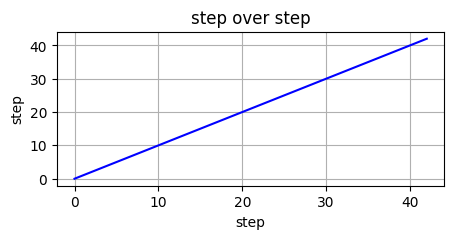

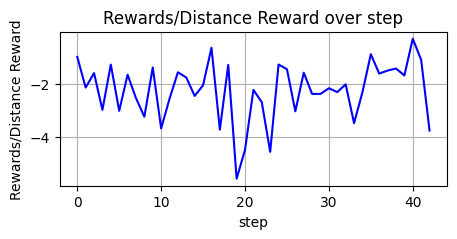

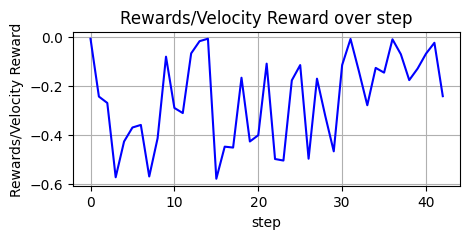

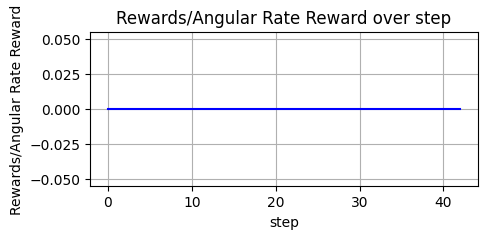

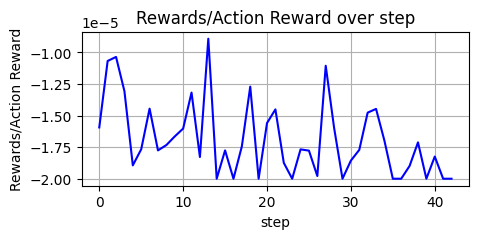

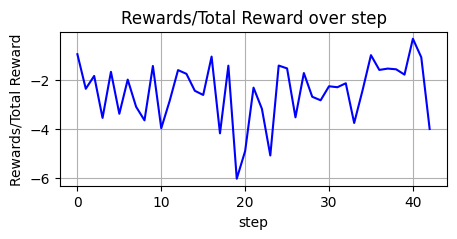

In [10]:
plot_columns(reward_no_imu_and_wind_df, 'step', reward_no_imu_and_wind_df.columns)

Study 2: IMU and wind

In [25]:
reward_log = event_files_to_dataframe('rotorpy/learning/logs/custom_metrics_imu_wind')

reward_df = process_custom_time_series(reward_log)


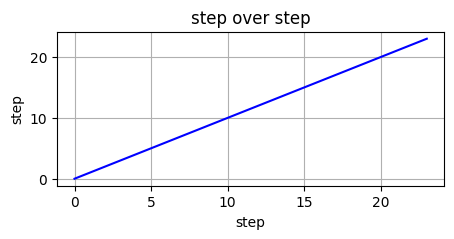

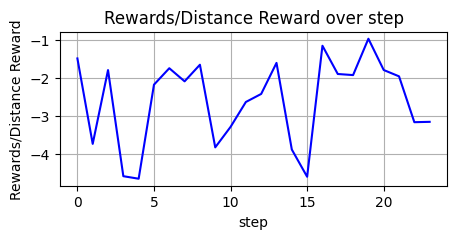

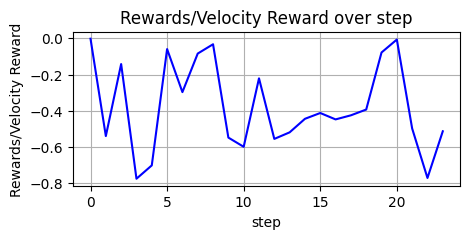

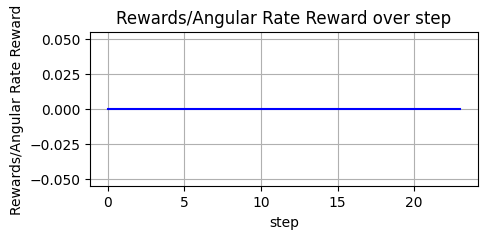

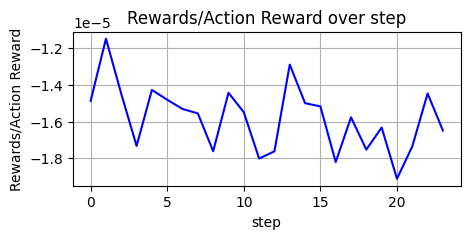

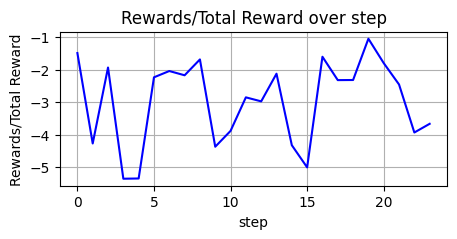

In [12]:
plot_columns(reward_df, 'step', reward_df.columns)

In [13]:
imu_wind_metrics = extract_tensorboard_data('rotorpy/learning/logs/metrics_imu_wind')
imu_wind_metrics_df = process_time_series(imu_wind_metrics)

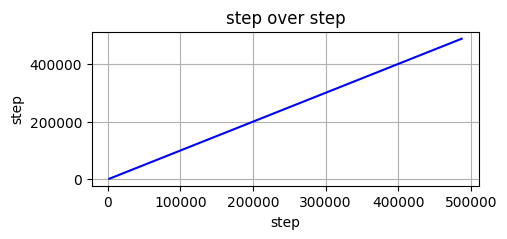

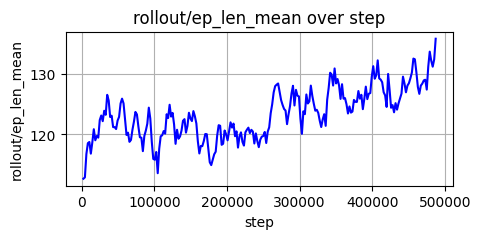

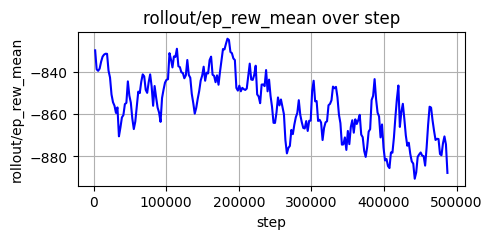

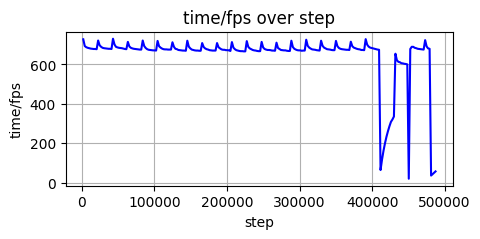

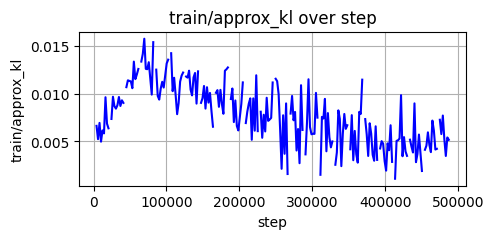

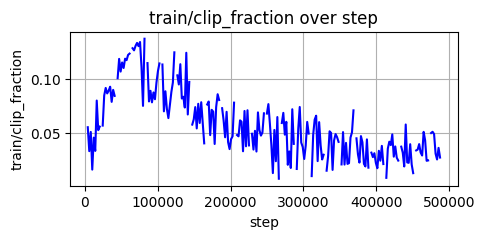

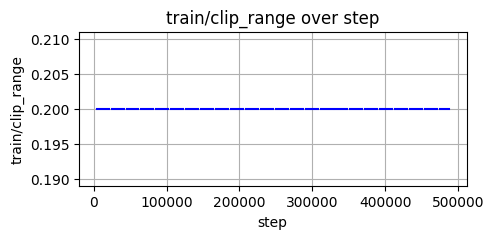

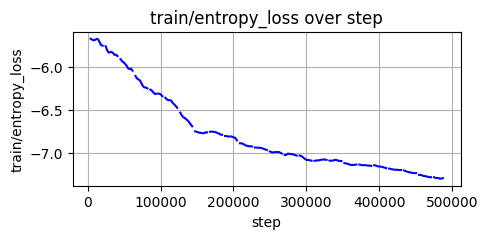

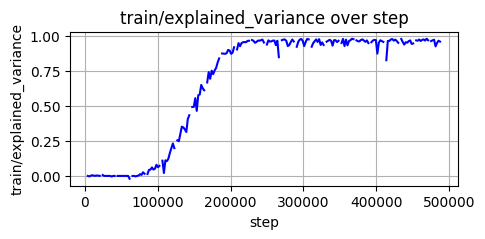

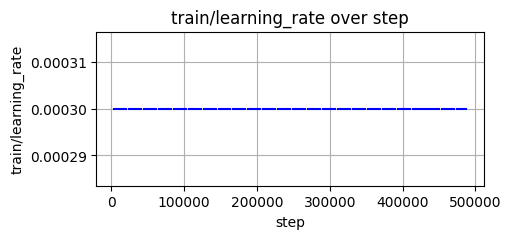

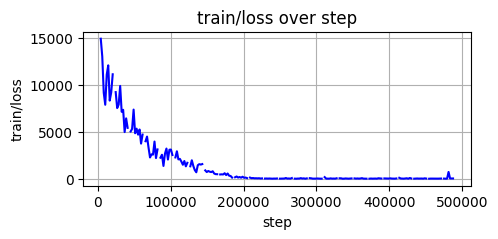

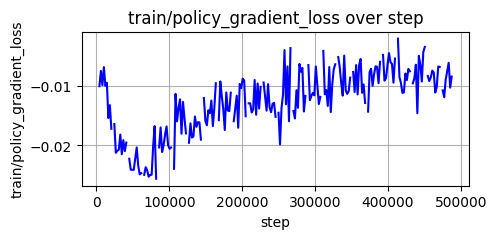

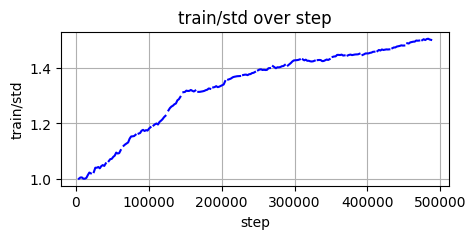

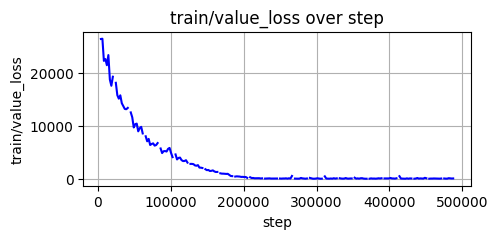

In [14]:
plot_columns(imu_wind_metrics_df, 'step', imu_wind_metrics_df.columns)

Comparison

Columns in reward_df: Index(['step', 'Rewards/Distance Reward', 'Rewards/Velocity Reward',
       'Rewards/Angular Rate Reward', 'Rewards/Action Reward',
       'Rewards/Total Reward'],
      dtype='object')
Columns in reward_no_imu_and_wind_df: Index(['step', 'Rewards/Distance Reward', 'Rewards/Velocity Reward',
       'Rewards/Angular Rate Reward', 'Rewards/Action Reward',
       'Rewards/Total Reward'],
      dtype='object')


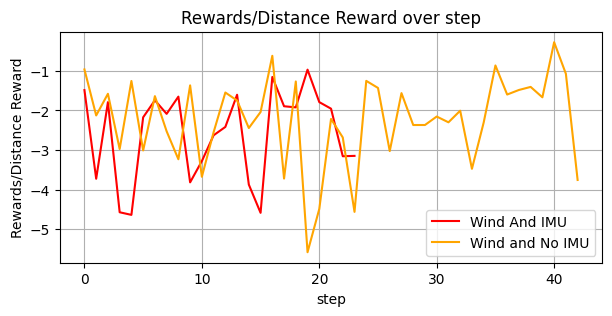

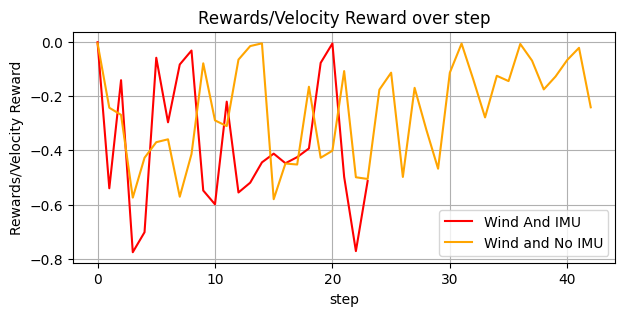

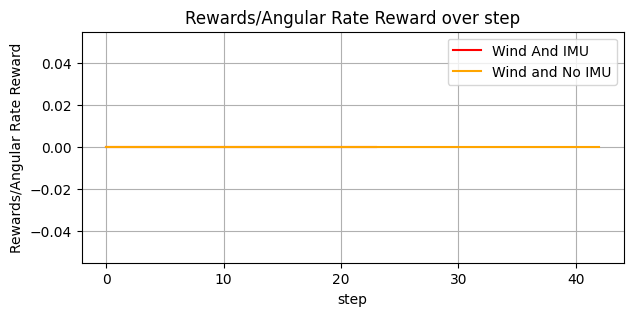

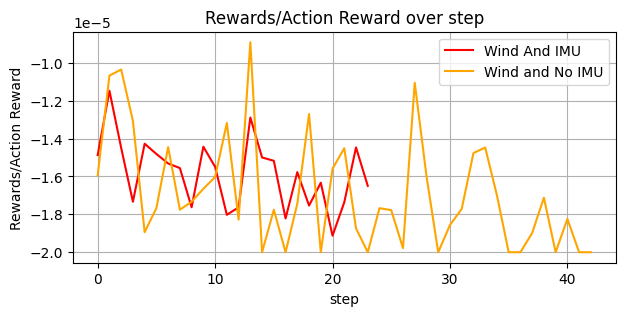

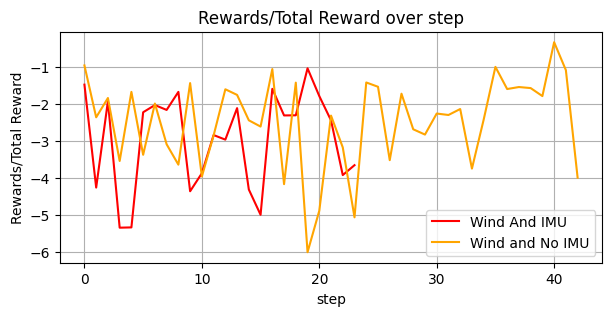

In [15]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt


if 'step' in reward_df.columns and 'step' in reward_no_imu_and_wind_df.columns:

    print("Columns in reward_df:", reward_df.columns)
    print("Columns in reward_no_imu_and_wind_df:", reward_no_imu_and_wind_df.columns)


    columns = reward_df.columns.tolist()
    columns.remove('step')

    for column in columns:
        if column in reward_no_imu_and_wind_df.columns:
            plt.figure(figsize=(7, 3))
            plt.plot(reward_df['step'], reward_df[column], color='red', label='Wind And IMU')
            plt.plot(reward_no_imu_and_wind_df['step'], reward_no_imu_and_wind_df[column], color='orange', label='Wind and No IMU')
            title = f'{column} over step'

            plt.title(title)
            plt.xlabel('step')
            plt.ylabel(column)
            plt.grid(True)
            plt.legend()

            plt.show()
        else:
            print(f"Column '{column}' not found in reward_no_imu_and_wind_df. Skipping plot for this column.")
else:
    print("The 'step' column is missing in one of the DataFrames.")


# Run the same simulation for providing wind 
# try running the 


Need some quantitative comparisons between the code

scenario 1 no knowledge of the wind
scenario 2 give ground truth wind
scenario 3 give policy measurements from the IMU 


Train model 1M time steps and then evaluate

Separate script thta is essentially like ppo hover eval 
Train for the same number of time steps trying to hover at the origin

After we stop training the model you want to Load run the environment 1000 times each per scenario and collect metrics and collect avg tracking error and different metrics

does not have to be through tensorboard logging at all
make boxplots that compare average tracking error 

Ideally want to see scenario 1 is the wrost model, ground truth wind is performing well and scenario with IMU measurements is somewhere in between 


Make the presentation 


if IMU model is bad, you can start with the policy that is trained with ground truth wind weights and then we retrain with IMU 

Presentation:
1) talk about how we wrote the code and the lessons learned from the code to explain to beginners how hard it is 


Box plots and quant analysis at a high level we want to ask how well can evaluate if providing IMU inforamation will give better restuls and if you can do that on a robot


Study 3 Wind ground truth

 1013760 Time steps

In [30]:
wind_gnd_reward = event_files_to_dataframe('rotorpy/learning/logs/custom_metrics_wind_gnd_truth_09-27-07_0')
wind_gnd_reward_df = process_custom_time_series(wind_gnd_reward)

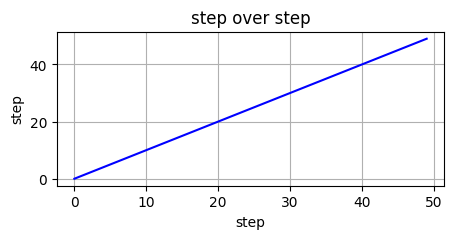

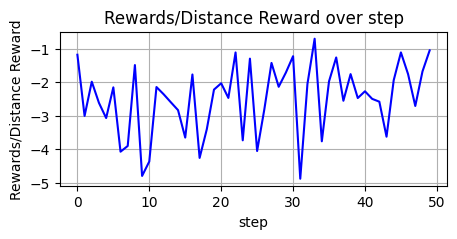

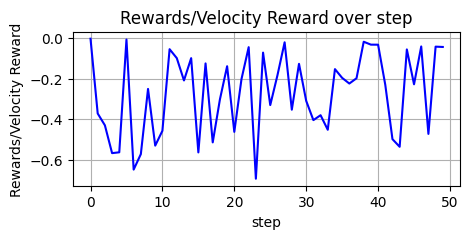

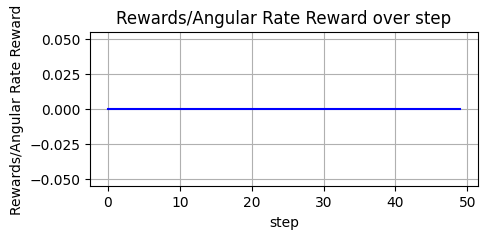

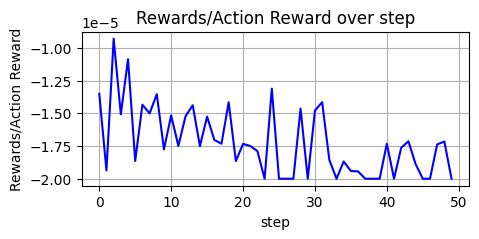

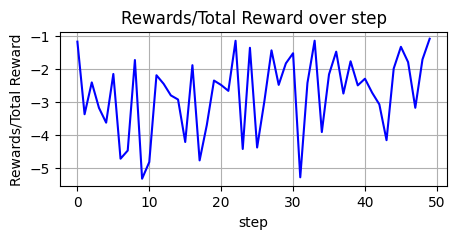

In [31]:
plot_columns(wind_gnd_reward_df, 'step', wind_gnd_reward_df.columns)

In [20]:
wind_gnd_df = extract_tensorboard_data('rotorpy/learning/logs/wind_gnd_truth_09-27-07_0')
wind_gnd_ts = process_time_series(wind_gnd_df)



Columns in wind_gnd_reward_df: Index(['step', 'Rewards/Distance Reward', 'Rewards/Velocity Reward',
       'Rewards/Angular Rate Reward', 'Rewards/Action Reward',
       'Rewards/Total Reward'],
      dtype='object')
Columns in reward_no_imu_and_wind_df: Index(['step', 'Rewards/Distance Reward', 'Rewards/Velocity Reward',
       'Rewards/Angular Rate Reward', 'Rewards/Action Reward',
       'Rewards/Total Reward'],
      dtype='object')


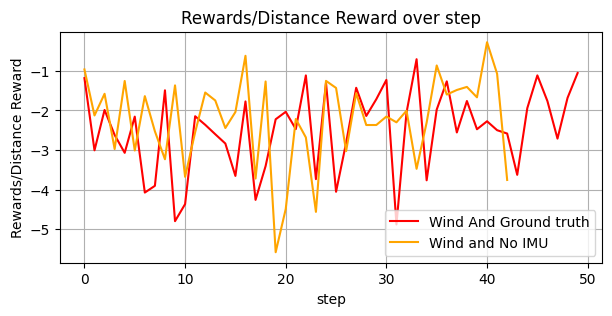

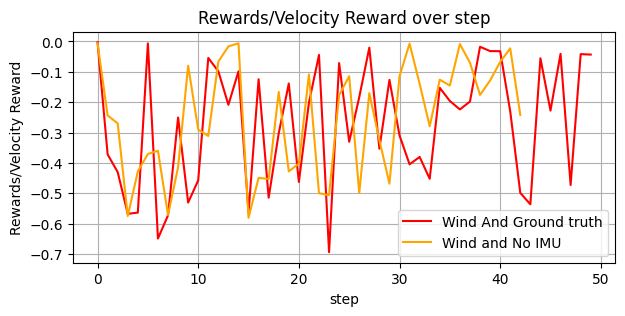

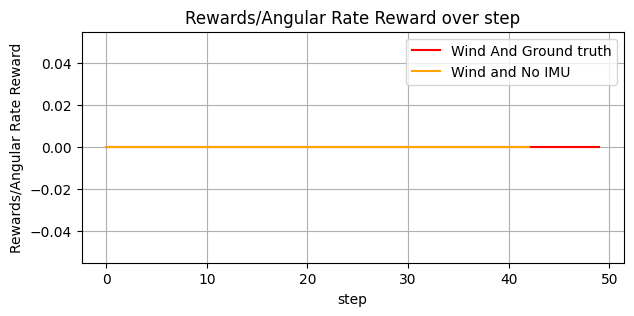

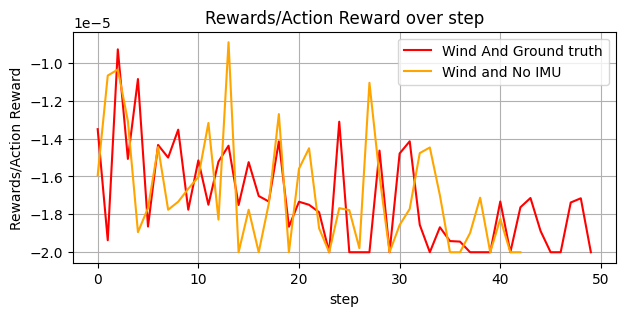

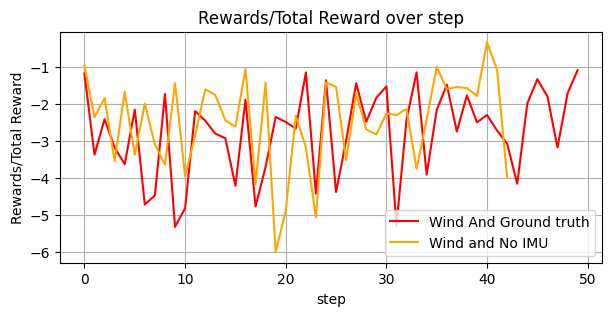

In [32]:

if 'step' in wind_gnd_reward_df.columns and 'step' in reward_no_imu_and_wind_df.columns:

    print("Columns in wind_gnd_reward_df:", wind_gnd_reward_df.columns)
    print("Columns in reward_no_imu_and_wind_df:", reward_no_imu_and_wind_df.columns)


    columns = reward_df.columns.tolist()
    columns.remove('step')

    for column in columns:
        if column in reward_no_imu_and_wind_df.columns:
            plt.figure(figsize=(7, 3))
            plt.plot(wind_gnd_reward_df['step'], wind_gnd_reward_df[column], color='red', label='Wind And Ground truth')
            plt.plot(reward_no_imu_and_wind_df['step'], reward_no_imu_and_wind_df[column], color='orange', label='Wind and No IMU')
            title = f'{column} over step'

            plt.title(title)
            plt.xlabel('step')
            plt.ylabel(column)
            plt.grid(True)
            plt.legend()

            plt.show()
        else:
            print(f"Column '{column}' not found in reward_no_imu_and_wind_df. Skipping plot for this column.")
else:
    print("The 'step' column is missing in one of the DataFrames.")
